## Quantile Regression
こちらの追試 https://github.com/ceshine/quantile-regression-tensorflow/blob/master/notebooks/03-sklearn-example-pytorch.ipynb
https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629

In [1]:
from functools import partial
from itertools import chain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}

import torch
import torch.nn as nn
np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

In [2]:
#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)
# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

X.shape, y.shape, xx.shape

((100, 1), (100,), (1000, 1))

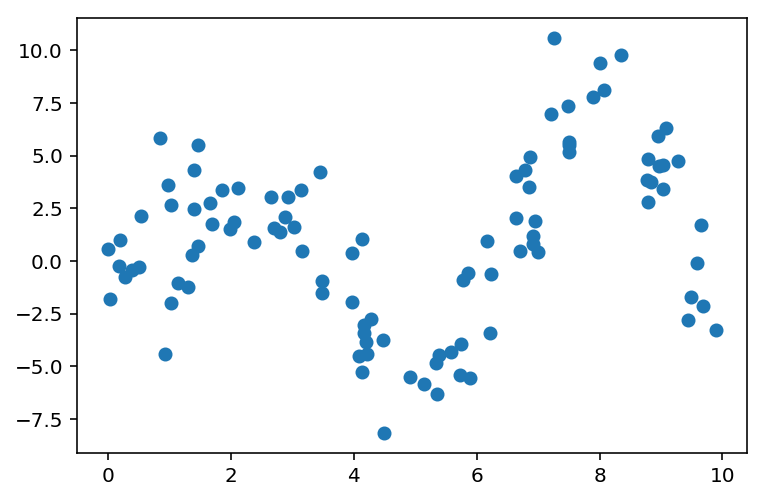

In [3]:
plt.scatter(X[:,0],y);

### モデルの構築

In [4]:
class q_model_simplified(nn.Module):
    def __init__(self,
                 quantiles,
                 in_shape=1,
                 dropout=0.5):
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 128),
            nn.ReLU(),
            # nn.BatchNorm1d(128),
            nn.Dropout(self.dropout),
            nn.Linear(128, self.out_shape) #最後のノード数だけもつ層を作る
        )
        
    def init_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        return self.model(x)

In [5]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

In [6]:
class Learner:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []
        
    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(
                    x[idx : min(idx + batch_size, x.shape[0]),:]
                ).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(
                    y[idx : min(idx + batch_size, y.shape[0])]
                ).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())                                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 500 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))
                
    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

### モデルの訓練

In [7]:
# Instantiate model
quantiles = [.05, .5, .95]
model = q_model_simplified(quantiles, dropout=0.1)
loss_func = QuantileLoss(quantiles)
learner = Learner(model, partial(torch.optim.Adam, weight_decay=1e-6), loss_func)

In [8]:
# Run training
epochs = 10000
learner.fit(X, y, epochs, batch_size=10)

Epoch 500: 1.6311531066894531
Epoch 1000: 1.502244234085083
Epoch 1500: 1.3895893096923828
Epoch 2000: 1.2918282747268677
Epoch 2500: 1.1683616638183594
Epoch 3000: 1.1992239952087402
Epoch 3500: 1.2474901676177979
Epoch 4000: 1.2454917430877686
Epoch 4500: 1.2349718809127808
Epoch 5000: 1.258723258972168
Epoch 5500: 1.1799867153167725
Epoch 6000: 1.2878859043121338
Epoch 6500: 1.292357325553894
Epoch 7000: 1.1062467098236084
Epoch 7500: 1.1954553127288818
Epoch 8000: 1.121607780456543
Epoch 8500: 1.0703152418136597
Epoch 9000: 1.2294092178344727
Epoch 9500: 1.2458168268203735
Epoch 10000: 1.1469218730926514


### 結果

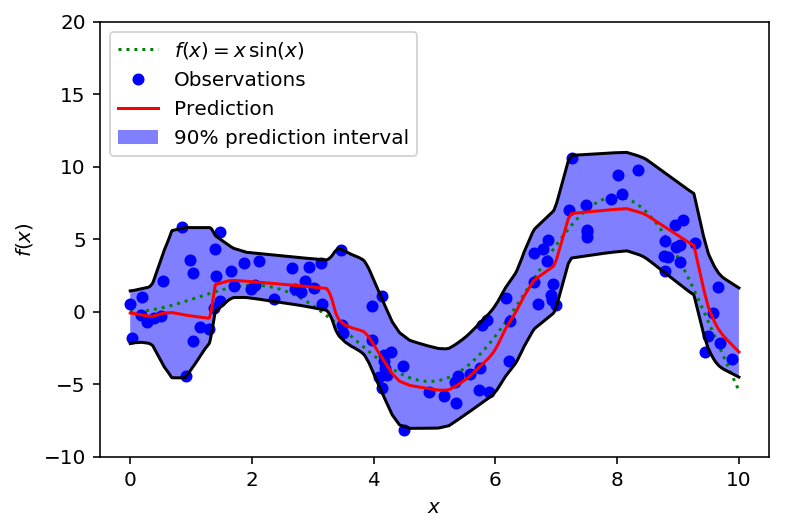

In [9]:
# Make the prediction on the meshed x-axis
tmp = learner.predict(xx)
y_lower, y_pred, y_upper = tmp[:, 0], tmp[:, 1], tmp[:, 2]

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()